# Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called __multi-class image classification__. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), tf.keras.applications, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called __transfer learning__. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

## Getting the workspace ready

In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.1.0


Let's run some import statements. And check whether or not we're using a GPU.

In [2]:
import tensorflow_hub as hub

print("Hub version:", hub.__version__)

# Check for GPU
#print("GPU", "Yes, available" if tf.config.list_physical_devices("GPU") else "Not Available")

Hub version: 0.8.0


## Accessing the data

Let's start with labels.csv which contains all of the image ID's and their assosciated dog breed (our data and labels).

*With all Machine Learning models, our data has to be in the numerical format. So that's what will be doing first. Turing images into Tensors (numerical representations).*

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Check the labels of data
labels_file = pd.read_csv("D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network/labels.csv")

print(labels_file.describe(), end='\n')

labels_file.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b82bc22d0ca3d81abafe53f12994d203  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Looking at this, we can see there are 10222 different ID's (meaning 10222 different images) and 120 different breeds.

Let's figure out how many images there are of each breed.

In [5]:
# Howw many images are their of each breed
labels_file['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

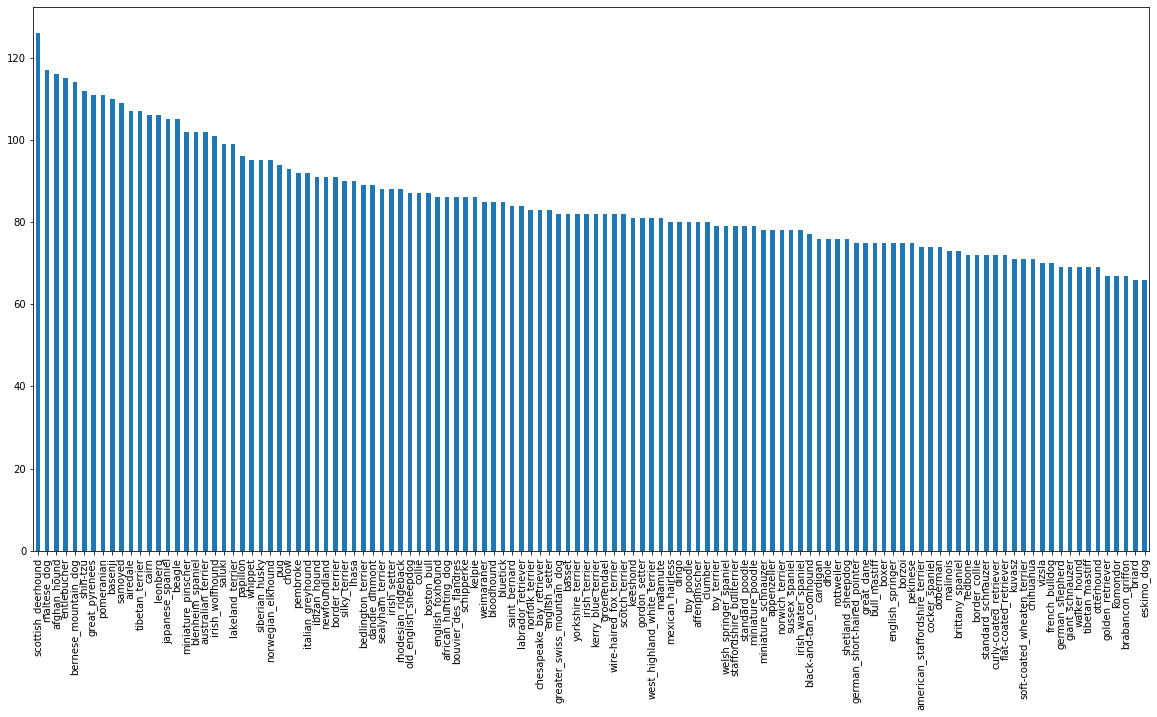

In [6]:
labels_file['breed'].value_counts().plot.bar(figsize=(20, 10))

In [7]:
labels_file['breed'].value_counts().mean()

85.18333333333334

If we were to roughly draw a line across the middle of the graph, we'd see there's about 60+ images for each dog breed.

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class](https://cloud.google.com/vision/automl/object-detection/docs/prepare) to get started. And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.

In [8]:
# Let's view an image
from IPython.display import display, Image

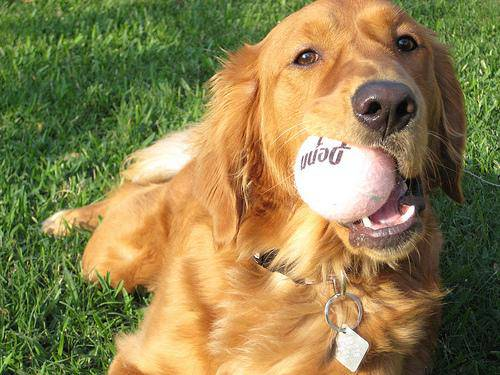

In [9]:
Image("D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/0d30e235aebdde78be6e2a59becb582d.jpg")

### Getting images and their labels
Since we've got the image ID's and their labels in a DataFrame (labels), we'll use it to create:

* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [10]:
labels_file.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Create pathnames from image ids
filenames = ["D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/" + fname + ".jpg" for fname in labels_file['id']]

# Check the list
filenames[:10]

['D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/001cdf01b096e06d78e9e5112d419397.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine L

In [12]:
# Check whether number of filenames matches the number of actual image files
import os
file_count = os.listdir("D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/")
file_count[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
if len(file_count) == len(filenames):
    print('Filenames match actual ammount of files')
else:
    print('Filesnames donot match')

Filenames match actual ammount of files


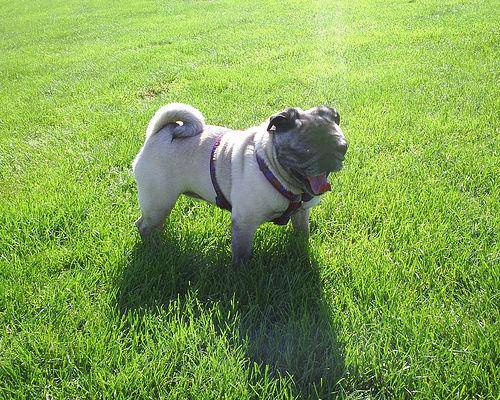

In [14]:
# Check an image directly from a filepath
Image(filenames[5010])

In [15]:
labels_file['breed'][5010]

'pug'

Now we've our training images filepaths in a list, let's prepare our labels

In [16]:
labels = labels_file['breed']
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [17]:
# Labels into numpy arrays
# 1. breed_labels = np.array(breed_labels)
# 2.
labels = labels_file['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels)

10222

In [19]:
# Check if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches the number of files")
else:
    print('Number of labels donot matches the number of filenames')

Number of labels matches the number of files


In [20]:
# Unique labels
unique_breed = np.unique(labels)
unique_breed

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [21]:
len(unique_breed)

120

In [22]:
# Turn a single label into boolean array
print(labels[10])
labels[10] == unique_breed

shetland_sheepdog


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [23]:
# Turn everylabel into boolean array
boolean_lables = [label == np.array(unique_breed) for label in labels]

In [24]:
boolean_lables[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [25]:
len(boolean_lables)

10222

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single dog breed name such as boston_bull into a one-hot array.

Let's see an example.

In [26]:
print(labels[0])
print(np.where(unique_breed == labels[0])) # index where label occurs
print(boolean_lables[0].argmax()) # index where label occurs in boolean array
print(boolean_lables[0].astype(int)) # there will be a 1 where smaple label occur

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [27]:
print(labels[2])
print(np.where(unique_breed == labels[2])) # index where label occurs
print(boolean_lables[2].argmax()) # index where label occurs in boolean array
print(boolean_lables[2].astype(int)) # there will be a 1 where smaple label occur

pekinese
(array([85], dtype=int64),)
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [28]:
filenames[:5]

['D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/001cdf01b096e06d78e9e5112d419397.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

### Creating the validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to X (data) and our labels to y.

In [29]:
# Setup X and Y variables
X = filenames
y = boolean_lables

In [30]:
len(filenames), len(boolean_lables)

(10222, 10222)

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [31]:
import ipywidgets as widgets

In [32]:
#widgets.IntSlider(min=-10, max=30, step=1, value=10)

In [33]:
# Set number of images to use for experiment
x = widgets.IntSlider(min=1000, max=10000, step=1000)
x

IntSlider(value=1000, max=10000, min=1000, step=1000)

In [34]:
NUM_IMAGES = x.value
NUM_IMAGES

1000

In [35]:
# Lets split the data into train and validation sets
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [37]:
# Lets look at the training data
X_train[:5], y[:2]

(['D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/00bee065dcec471f26394855c5c2f3de.jpg',
  'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, Fa

## Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, example: __image__
.
3. Turn our *image* (a jpeg file) into Tensors.
4. Normalize our *image* (convert color channel values from 0-255 to 0-1 vlaues)
5. Resize the *image* to be of shape (224, 224).
6. Return the modified *image*.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images).

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.

In [38]:
# Convert an image to numpy array
from matplotlib.pyplot import imread

In [39]:
image = imread(filenames[50])
image.shape

(240, 320, 3)

In [40]:
image

array([[[176, 163, 146],
        [157, 144, 127],
        [148, 135, 118],
        ...,
        [109,  94,  99],
        [ 76,  60,  70],
        [ 76,  58,  70]],

       [[168, 155, 138],
        [148, 135, 118],
        [150, 137, 120],
        ...,
        [100,  85,  88],
        [ 64,  49,  56],
        [ 87,  70,  80]],

       [[149, 133, 117],
        [126, 113,  96],
        [144, 131, 114],
        ...,
        [108,  94,  93],
        [ 72,  57,  60],
        [ 67,  50,  56]],

       ...,

       [[ 92,  75,  65],
        [ 87,  70,  60],
        [ 76,  62,  51],
        ...,
        [253, 241, 217],
        [254, 242, 220],
        [255, 244, 222]],

       [[ 89,  72,  62],
        [ 86,  69,  59],
        [ 77,  63,  52],
        ...,
        [253, 240, 223],
        [251, 238, 221],
        [249, 236, 220]],

       [[ 85,  68,  58],
        [ 87,  70,  60],
        [ 83,  69,  58],
        ...,
        [255, 244, 228],
        [253, 239, 226],
        [249, 235, 222]]

Notice the shape of image. It's (240, 320, 3). This is height, width, colour channel value.

And you can easily convert it to a Tensor using [tf.constant()](https://www.tensorflow.org/api_docs/python/tf/constant).

In [41]:
image[:2]

array([[[176, 163, 146],
        [157, 144, 127],
        [148, 135, 118],
        ...,
        [109,  94,  99],
        [ 76,  60,  70],
        [ 76,  58,  70]],

       [[168, 155, 138],
        [148, 135, 118],
        [150, 137, 120],
        ...,
        [100,  85,  88],
        [ 64,  49,  56],
        [ 87,  70,  80]]], dtype=uint8)

In [42]:
# turned image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 320, 3), dtype=uint8, numpy=
array([[[176, 163, 146],
        [157, 144, 127],
        [148, 135, 118],
        ...,
        [109,  94,  99],
        [ 76,  60,  70],
        [ 76,  58,  70]],

       [[168, 155, 138],
        [148, 135, 118],
        [150, 137, 120],
        ...,
        [100,  85,  88],
        [ 64,  49,  56],
        [ 87,  70,  80]]], dtype=uint8)>

__*Function to convert images into tensors*__

In [43]:
# Example
tensor = tf.io.read_file(filenames[40])
tensor = image = tf.image.decode_jpeg(tensor, channels=3)
tensor = tf.image.convert_image_dtype(tensor, tf.float32) #Normalization
tensor

<tf.Tensor: shape=(293, 400, 3), dtype=float32, numpy=
array([[[1.        , 0.9725491 , 0.9725491 ],
        [0.98823535, 0.9333334 , 0.9333334 ],
        [0.9803922 , 0.93725497, 0.9294118 ],
        ...,
        [0.43921572, 0.6431373 , 0.34901962],
        [0.38431376, 0.59607846, 0.3019608 ],
        [0.3647059 , 0.57254905, 0.2901961 ]],

       [[1.        , 0.9803922 , 0.9607844 ],
        [1.        , 0.98823535, 0.9607844 ],
        [0.9960785 , 0.9686275 , 0.93725497],
        ...,
        [0.37647063, 0.5803922 , 0.28627452],
        [0.34117648, 0.54509807, 0.2627451 ],
        [0.34901962, 0.5568628 , 0.27450982]],

       [[0.9215687 , 0.9333334 , 0.8588236 ],
        [0.9490197 , 0.9607844 , 0.87843144],
        [0.8980393 , 0.909804  , 0.82745105],
        ...,
        [0.33333334, 0.5372549 , 0.24313727],
        [0.32941177, 0.53333336, 0.2509804 ],
        [0.36862746, 0.5686275 , 0.29803923]],

       ...,

       [[0.4784314 , 0.54901963, 0.30588236],
        [0.45

In [44]:
# Define the image size
IMG_SIZE = 224

# Function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a tensor.
    """
    # Read an image file
    image = tf.io.read_file(image_path)
    # Trun the jpeg image into numerical tensor with 3 color channels(Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to desired values (224, 244)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    
    return image

### Creating data batches

Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow [BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

What's a __batch__?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of *process_image* function at the same time.

In [45]:
# Create a function to return a tuple(image, label)
def get_image_label(image_path, label):
    """
    Take an image file path and associated label,
    processess the image and return a tuple of image and label.
    """
    
    image = process_image(image_path)
    
    return image, label

In [46]:
# Demo
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

dhole


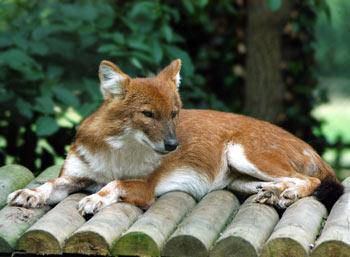

In [47]:
print(labels_file['breed'][42])
Image(filenames[42])

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [48]:
# Define a batch size
BATCH_SIZE = 32

# Create a function to trun data into batches
def create_data_batches(X, y=None, batch_szie=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and labels (y) pairs.
    Shuffles the data if it's a training data but doesn't shuffle if it is a validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a Test dataset, we probably don't have labels
    if test_data:
        print('Creating test data batches....!', end='\n')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # create dataset from tensors
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a Valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating valid data batches....!', end='\n')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is Training dataset
    else:
        print('Creating training data batches....!', end='\n')
        #Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling the pathnames and labels before mapping processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create image, label tuples (this also truns the image paths into a preprocessed image)
        data = data.map(get_image_label)
        # Trun the data into batches
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch

In [49]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches....!
Creating valid data batches....!


In [50]:
# Check out the different attributes of data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [51]:
# Create a fucntion viewing images in data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 imagesand their labels from a data batch
    """
    # Set up the figure
    plt.figure(figsize=(12, 12))
    # Loop through 25
    for i in range(25):
        # Create sublpots (5 rows, 5 columns)
        ax = plt.subplot(5,5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as title
        plt.title(unique_breed[labels[i].argmax()])
        # Trun the grind lines off
        plt.axis('off')

In [52]:
unique_breed[y[0].argmax()]

'boston_bull'

In [53]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [54]:
# take batch dataset and unwind it and trun into numpy iterator
train_images, train_labels = next(train_data.as_numpy_iterator())

In [55]:
len(train_images), len(train_labels)

(32, 32)

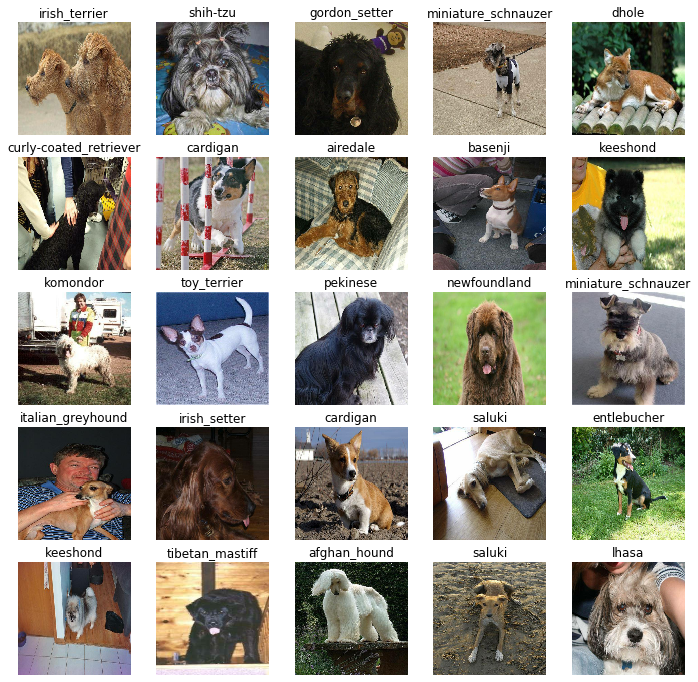

In [56]:
# Now let's visualize the data in the training batch
show_25_images(train_images, train_labels)

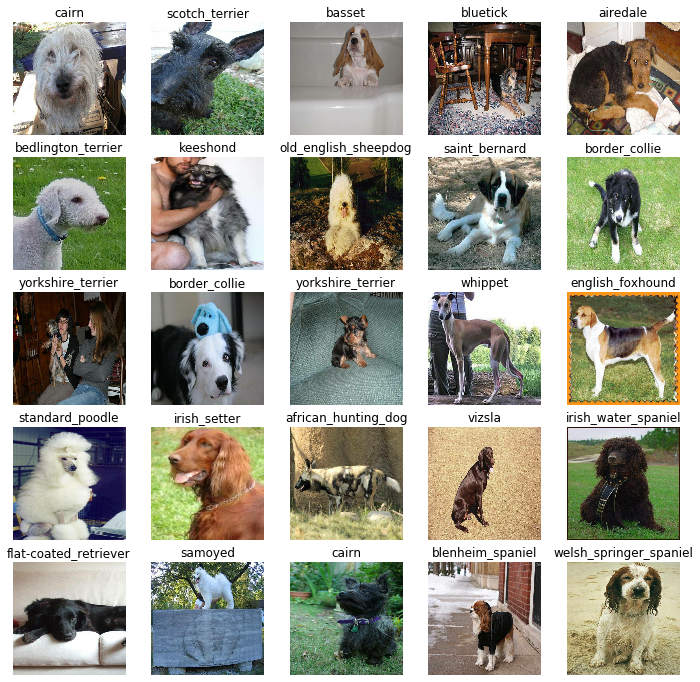

In [57]:
# Now lets visualize the valid set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as __transfer learning__.

__Why use a pretrained model?__

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

__How do we choose a model?__

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224 model](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4), tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:

* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [58]:
IMG_SIZE

224

In [59]:
len(unique_breed)

120

In [60]:
# Setup the input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channels

# Setup the output shape of the model
OUTPUT_SHAPE = len(unique_breed)

# Setup the model URL from the Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to use the [Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

We'll take a look at the code first, then dicuss each part.

In [61]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print('Building with: ', model_url)
    
    # Setup model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), #Layer 1(input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                             activation='softmax') #Layer 2(output layer)
    ])
    
    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

*What's happening here?*

__Setting up the model layers__

There are two ways to do this in Keras, the [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential](https://www.tensorflow.org/guide/keras/overview#build_a_simple_model) API. We've used the sequential.

Which one should you use?

The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (a linear stack of layers) is perfectly fine for getting started, which is what we're doing.

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`). So our first layer is actually an entire model (many more layers). This __input layer__ takes in our images and finds patterns in them based on the patterns [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) has found.

The next layer (`tf.keras.layers.Dense()`) is the __output layer__ of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

For more on which activation function to use, see the article [Which Loss and Activation Functions Should I Use?](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)

__Compiling the model__

This one is best explained with a story.

Let's say you're at the international hill descending championships. Where your start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to `model.compile()` terminology:

* *loss* - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* *optimizer* - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* *metrics* - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

__Building the model__

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as None as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call `summary()` on our model to get idea of what our model looks like.

In [62]:
%%time

model = create_model()
model.summary()

Building with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
Wall time: 2.83 s


The non-trainable parameters are the patterns learned by *mobilenet_v2_130_224* and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

## Creating Callbacks

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:

1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize the our models training logs using the `%tensorboard magic function` (we'll do this later on).

In [63]:
# Load Tensorboard notebook extension
%load_ext tensorboard

In [64]:
import datetime
import os

# Create a function to build tensorboard callback
def create_tensorboard_callback():
    # Create a log directory storing tensorboard logs
    logdir = os.path.join("Logs",
                         # make it so the logs get tracked whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=3)

## Training a model (on a subset of data)

Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is NUM_EPOCHS (also known as __number of epochs__).

NUM_EPOCHS defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If NUM_EPOCHS=1, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for NUM_EPOCHS?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set NUM_EPOCHS to 100 but our model stops improving after 22 epochs, it'll stop training.

In [66]:
# Set number of epochs for training
ep = widgets.IntSlider(min=10, max=100, step=10)
ep

IntSlider(value=10, min=10, step=10)

In [67]:
NUM_EPOCHS = ep.value
NUM_EPOCHS

10

Let's create a simple function which trains a model. The function will:

* Create a model using create_model().
* Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).
* Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [68]:
# Build a function to train and retrun the trained model
def train_model():
    """
    Trains the given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    
    # Create new Tensorboard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data, passing it the callbacks we created
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data= valid_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])
    
    # Retun the fitted model
    return model

In [69]:
%%time

# Fit the model to the data
model = train_model()

Building with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 25s 981ms/step - loss: 4.4915 - accuracy: 0.1000 - val_loss: 3.3982 - val_accuracy: 0.2650
Epoch 2/10
25/25 [==============================] - 21s 820ms/step - loss: 1.6115 - accuracy: 0.6862 - val_loss: 2.1790 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 21s 825ms/step - loss: 0.5573 - accuracy: 0.9325 - val_loss: 1.6824 - val_accuracy: 0.5800
Epoch 4/10
25/25 [==============================] - 24s 948ms/step - loss: 0.2499 - accuracy: 0.9887 - val_loss: 1.4716 - val_accuracy: 0.6150
Epoch 5/10
25/25 [==============================] - 24s 947ms/step - loss: 0.1453 - accuracy: 0.9975 - val_loss: 1.3845 - val_accuracy: 0.6250
Epoch 6/10
25/25 [==============================] - 22s 881ms/step - loss: 0.0995 - accuracy: 1.0000 - val_loss: 1.3361 - val_accuracy: 0.6400
Epoch 7/10
25

__Question__: It looks like our model might be overfitting (getting far better results on the training set than the validation set), what are some ways to prevent model overfitting? Hint: this may involve searching something like "ways to prevent overfitting in a deep learning model?".

__Note__: Overfitting to begin with is a good thing. It means our model is learning something.

__Checking the TensorBoard logs__

Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [70]:
%tensorboard --logdir 'Logs'

Reusing TensorBoard on port 6006 (pid 11068), started 1 day, 22:28:48 ago. (Use '!kill 11068' to kill it.)

### Making and evaluating predictions using a trained model

Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling *predict()* on it and passing it data in the same format the model was trained on.

In [71]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [72]:
# Make predictions on the valiation data (not used to train on)
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 5s 669ms/step


array([[3.06980941e-03, 1.02476246e-04, 4.57289722e-03, ...,
        4.45204874e-04, 4.04882448e-05, 1.64064043e-03],
       [1.32653990e-03, 1.16142211e-03, 1.43536758e-02, ...,
        2.00836934e-04, 1.04350690e-03, 1.00013996e-04],
       [3.87580112e-05, 2.79888282e-05, 4.24646023e-05, ...,
        3.43237771e-05, 7.78497997e-05, 4.97405053e-05],
       ...,
       [3.15951979e-06, 5.09437014e-05, 3.95702518e-05, ...,
        2.14244155e-05, 1.24837723e-04, 4.02533100e-04],
       [9.88320727e-03, 2.50817509e-04, 1.67657563e-04, ...,
        3.23224231e-04, 4.45640180e-05, 5.77510595e-02],
       [2.21735143e-04, 7.55484289e-05, 2.54298298e-04, ...,
        2.47109961e-03, 4.47062688e-04, 7.22899786e-05]], dtype=float32)

In [73]:
predictions.shape

(200, 120)

In [74]:
len(y_val), len(unique_breed)

(200, 120)

In [75]:
predictions[0]

array([3.06980941e-03, 1.02476246e-04, 4.57289722e-03, 8.40607740e-04,
       3.85850522e-04, 9.53785493e-05, 1.04025871e-01, 4.55635483e-04,
       2.82055058e-04, 3.51510267e-03, 2.38014822e-04, 4.47210419e-04,
       9.77104413e-04, 4.30760294e-04, 3.96729767e-04, 1.32996554e-03,
       8.53563324e-05, 5.07855676e-02, 1.61732642e-05, 7.58268943e-05,
       1.44561066e-03, 1.97617832e-04, 2.84985035e-05, 5.21982554e-03,
       2.96894814e-05, 1.16419797e-04, 3.24007630e-01, 1.39814583e-04,
       1.11911690e-03, 3.87895416e-04, 3.37108242e-04, 5.11546852e-03,
       1.00787007e-03, 1.89764396e-05, 1.35211521e-04, 2.95124352e-02,
       6.69551155e-05, 7.04809267e-04, 1.60967815e-04, 1.67074963e-04,
       2.43806327e-03, 4.47860657e-05, 2.06444660e-04, 4.30099608e-04,
       6.02378532e-05, 1.99586822e-04, 3.33298231e-05, 3.38854879e-04,
       1.05092954e-03, 1.52697467e-04, 3.41871695e-04, 7.09861342e-05,
       8.57562176e-04, 2.20952614e-04, 8.38771157e-05, 5.03095973e-04,
      

In [76]:
len(predictions[0])

120

In [77]:
np.sum(predictions[0])

0.9999999

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (predictions) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Let's see how we'd convert an array of probabilities into an actual label.

In [78]:
# First prediction
index = 50
print('Predictions', end='\n')
print(predictions[index], end='\n')
print(f'Max value (probability of prediction): {np.max(predictions[index])}', end='\n')
print(f'Sum: {np.sum(predictions[index])}', end='\n')
print(f'Max index: {np.argmax(predictions[index])}', end='\n')
print(f'Predicted label: {unique_breed[np.argmax(predictions[index])]}', end='\n')

Predictions
[1.22938724e-03 3.73827992e-04 4.14293306e-03 3.07118869e-04
 2.58789659e-01 1.99228362e-03 1.37486975e-04 1.80183630e-02
 3.80965736e-04 1.15651983e-05 1.58736861e-04 8.18389468e-04
 1.01979042e-03 4.24629543e-05 1.11036330e-04 2.20568381e-05
 1.01920858e-03 1.12004741e-03 1.66234986e-05 1.61324553e-02
 5.24363015e-04 2.12223385e-03 5.14655039e-05 2.89395510e-04
 1.17522264e-04 4.40858211e-03 5.71644341e-04 3.82936560e-04
 8.91566277e-04 5.71459578e-03 4.20393277e-04 5.23245253e-04
 1.03712443e-03 4.33773361e-03 1.89296005e-03 1.35738193e-03
 2.68442207e-04 6.82657585e-04 3.60838545e-04 6.78932120e-05
 5.60901317e-05 1.98564120e-03 9.06649418e-03 1.36503915e-03
 5.43075521e-03 9.11327486e-04 3.15902325e-05 8.88241164e-04
 3.80253565e-04 1.36312869e-04 1.18579512e-04 3.85709631e-04
 1.92496314e-04 1.39279140e-03 4.24349593e-04 7.88652455e-04
 7.93918207e-06 1.00512247e-04 8.09700810e-04 3.60504055e-04
 1.29338063e-03 3.14925623e-04 1.37781506e-04 5.18654939e-04
 6.07890077e

In [79]:
unique_breed[104]

'staffordshire_bullterrier'

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

__Note__: Prediction probabilities are also known as confidence levels.

In [80]:
# Turn prediction probabilites into their respective labels
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilites into a label.
    """
    return unique_breed[np.argmax(prediction_probabilities)]

In [81]:
# Get a predicted label based on a array of prediction probabilites
pred_label = get_pred_label(predictions[20])
pred_label

'flat-coated_retriever'

In [82]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the fit() function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it ([using unbatch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [as_numpy_iterator()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [83]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in valid_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)
    
images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [84]:
get_pred_label(labels_[10])

'yorkshire_terrier'

In [85]:
get_pred_label(predictions[10])

'irish_terrier'

In [86]:
# Function to unbatch the batched data
def unbatchify(data):
    """
    Take a batched dataset of (image, label) Tensors and returns separate arrays 
    of images and labels.
    """
    images_ = []
    labels_ = []
    
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breed[np.argmax(label)])
        
    return images_, labels_

In [87]:
# Unbatchifying the valid dataset
val_images, val_labels = unbatchify(valid_data)

val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [88]:
get_pred_label(val_labels[10])

'affenpinscher'

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [89]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n.
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the pre label
    pred_label = get_pred_label(pred_prob)
    
    # Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the title depending if theprediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label),
                                     color=color)

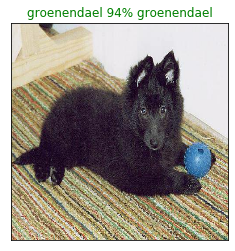

In [90]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images,
         n=77)

Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [91]:
def plot_pred_conf(prediction_probablities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probablities[n], labels[n]
    
    # Get predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 predictions confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    
    # Find the 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breed[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                      color='grey')
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation='vertical')
    
    # Change the color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass

In [92]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.32400763, 0.10402587, 0.09226605, 0.05078557, 0.04531024,
       0.03774349, 0.03400633, 0.03125728, 0.02951244, 0.02899798],
      dtype=float32)

In [93]:
predictions[0].max()

0.32400763

In [94]:
unique_breed[predictions[0].argsort()[-10:][::-1]]

array(['cairn', 'australian_terrier', 'soft-coated_wheaten_terrier',
       'border_terrier', 'miniature_schnauzer', 'irish_wolfhound',
       'standard_schnauzer', 'lhasa', 'dandie_dinmont', 'otterhound'],
      dtype=object)

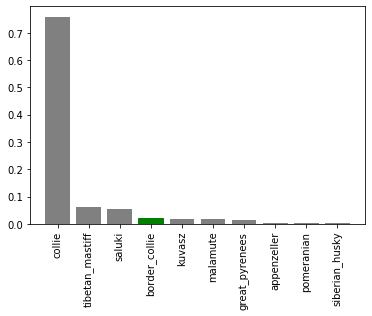

In [95]:
plot_pred_conf(prediction_probablities=predictions,
              labels=val_labels,
              n=9)

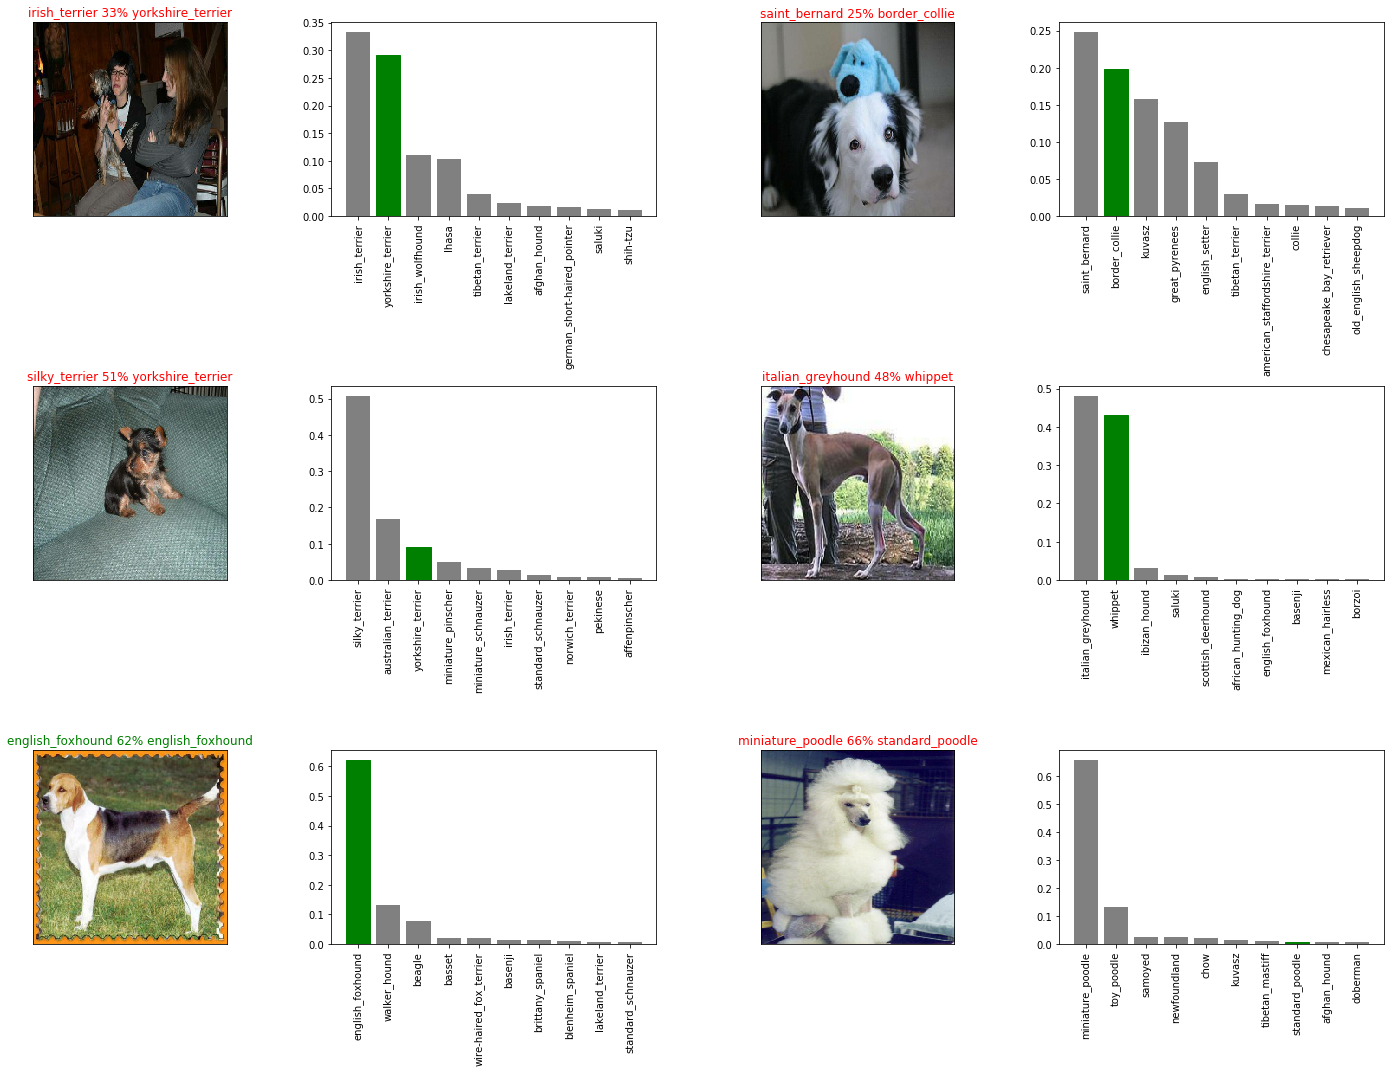

In [96]:
# Lets check few predictions and thier different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probablities=predictions,
                  labels=val_labels,
                  n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading the model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.

In [97]:
# Function to save a model
import datetime
import os

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix(string).
    """
    # Create a model directory pathname and current time
    modeldir = os.path.join("Models",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the [tf.keras.models.load_model()](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) function to load it into the notebook.

Because we're using a component from TensorFlow Hub (hub.KerasLayer) we'll have to pass this as a parameter to the `custom_objects` parameter.

In [98]:
# Function to load a model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [99]:
# Save our model trained on 1000 images
save_model(model, suffix='1000-images-mobilenetv2-Adam')

Saving model to: Models\20200507-145745-1000-images-mobilenetv2-Adam.h5...


'Models\\20200507-145745-1000-images-mobilenetv2-Adam.h5'

In [100]:
# Load the trained model
loaded_1000_image_model = load_model('Models\\20200506-171739-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: Models\20200506-171739-1000-images-mobilenetv2-Adam.h5


Compare the two models (the original one and loaded one). We can do so easily using the evaluate() method.

In [101]:
# Evaluate a pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 4s 604ms/step - loss: 1.2480 - accuracy: 0.6450


[1.2479528614452906, 0.645]

In [102]:
# Evaluate a loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 5s 651ms/step - loss: 1.2805 - accuracy: 0.6750


[1.280466045652117, 0.675]

## Training the model (On full data set)

Above, we saved all of the training filepaths to X and all of the training labels to y. Let's check them out.

In [103]:
# Length of all of training data
len(X), len(y)

(10222, 10222)

There we go! We've got over 10,000 images and labels in our training set.

Before we can train a model on these, we'll have to turn them into a data batch.

The beautiful thing is, we can use our `create_data_batches()` function from above which also preprocesses our images for us (thank you past us for writing a helpful function).

In [104]:
# Create a data batch with full data set
full_data = create_data_batches(X, y)

Creating training data batches....!


In [105]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [106]:
# Create a model for full data
full_model = create_model()

Building with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [107]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                            patience=3)

__Note__: Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our full_model_early_stopping callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [108]:
%%time

# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Train for 320 steps
Epoch 1/10
320/320 [==============================] - 243s 759ms/step - loss: 1.3007 - accuracy: 0.6764
Epoch 2/10
320/320 [==============================] - 219s 684ms/step - loss: 0.3968 - accuracy: 0.8826
Epoch 3/10
320/320 [==============================] - 226s 705ms/step - loss: 0.2359 - accuracy: 0.9351
Epoch 4/10
320/320 [==============================] - 229s 714ms/step - loss: 0.1498 - accuracy: 0.9648
Epoch 5/10
320/320 [==============================] - 228s 712ms/step - loss: 0.1046 - accuracy: 0.9793
Epoch 6/10
320/320 [==============================] - 230s 718ms/step - loss: 0.0776 - accuracy: 0.9859
Epoch 7/10
320/320 [==============================] - 226s 707ms/step - loss: 0.0581 - accuracy: 0.9925
Epoch 8/10
320/320 [==============================] - 233s 728ms/step - loss: 0.0454 - accuracy: 0.9948
Epoch 9/10
320/320 [==============================] - 213s 666ms/step - loss: 0.0378 - accuracy: 0.9962
Epoch 10/10
320/320 [=======================

In [109]:
# Saving the full data model
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: Models\20200507-153545-full-image-set-mobilenetv2-Adam.h5...


'Models\\20200507-153545-full-image-set-mobilenetv2-Adam.h5'

In [110]:
# Loading the full model
loaded_full_model = load_model('Models\\20200507-010307-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: Models\20200507-010307-full-image-set-mobilenetv2-Adam.h5


## Making predictions on test data set

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using *create_data_batches()* and setting the *test_data* parameter to __True__ (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the *predict()* function.

In [111]:
# Load test images filenames
import os

test_path = "D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/000621fb3cbb32d8935728e48679680e.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/00102ee9d8eb90812350685311fe5890.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'D:\\TUTORIALS\\Exercise Files - Complete Machine Learnin

In [112]:
len(test_filenames)

10357

In [113]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches....!


In [114]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

__Note__: Calling *predict()* on our full model and passing it to the test data will take long time to run.

In [115]:
%%time

# Make predictions on test data batch using loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                            verbose=1)

324/324 [==============================] - 217s 671ms/step
Wall time: 3min 37s


In [116]:
# Save prediction (NumPy array) to csv file
np.savetxt('test_preds_array.csv', test_predictions, delimiter=",")

In [117]:
# Load predictions from csv file
loaded_test_preds = np.loadtxt('test_preds_array.csv', delimiter=",")

In [118]:
loaded_test_preds[:10]

array([[1.87660356e-11, 6.29988900e-12, 9.09728039e-15, ...,
        8.50438426e-14, 5.44347012e-10, 5.04547792e-11],
       [2.99764997e-06, 1.34189702e-06, 1.99625791e-08, ...,
        9.19376034e-11, 2.24579665e-07, 3.48074014e-09],
       [9.97440880e-11, 6.92280366e-07, 5.83676663e-09, ...,
        8.63865068e-08, 7.12534337e-11, 2.85814098e-11],
       ...,
       [2.09579909e-09, 6.19791163e-10, 4.62454797e-11, ...,
        7.32549004e-12, 1.09672861e-11, 2.48218945e-10],
       [7.24283550e-11, 1.10670795e-09, 2.79254425e-10, ...,
        1.24335452e-06, 2.08506847e-08, 1.10967922e-10],
       [6.60821220e-09, 2.06485558e-11, 2.72814882e-10, ...,
        3.53272641e-12, 1.79811666e-10, 1.81954405e-07]])

In [119]:
test_predictions.shape, loaded_test_preds.shape

((10357, 120), (10357, 120))

### Preparing test dataset for Kaggle submission

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the *unique_breeds* list and the *test_predictions* list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [120]:
#['id'] + list(unique_breed)

In [121]:
# Create a pandas dataframe
preds_df = pd.DataFrame(columns=['id'] + list(unique_breed))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [122]:
# Append test image ID's to predictions dataframe
import os

test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [123]:
os.path.splitext(test_filenames[0])

('D:\\TUTORIALS\\Exercise Files - Complete Machine Learning and Data Science Zero to Mastery\\6- Neural Network\\test/000621fb3cbb32d8935728e48679680e',
 '.jpg')

In [124]:
test_ids[:10]

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442']

In [125]:
preds_df["id"] = test_ids

In [126]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# Add the prediction probabilitis to each dog breed column
preds_df[list(unique_breed)] = test_predictions

In [128]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.8766e-11,6.29989e-12,9.09728e-15,5.99784e-14,5.4455e-13,1.28369e-11,1.94019e-15,1.15015e-12,9.84968e-13,...,4.02905e-12,2.68666e-13,1.40743e-13,1.55876e-14,3.87878e-14,2.44814e-12,1.07635e-12,8.50438e-14,5.44347e-10,5.04548e-11
1,00102ee9d8eb90812350685311fe5890,2.99765e-06,1.3419e-06,1.99626e-08,5.46573e-09,8.16156e-07,4.50831e-08,5.31242e-07,5.50419e-07,3.41864e-08,...,9.99154e-08,9.69622e-07,6.04794e-09,9.08265e-06,7.05636e-08,2.42117e-07,0.000392445,9.19376e-11,2.2458e-07,3.48074e-09
2,0012a730dfa437f5f3613fb75efcd4ce,9.97441e-11,6.9228e-07,5.83677e-09,3.77281e-10,5.16989e-11,3.66418e-08,1.53437e-10,7.39897e-12,4.03561e-09,...,9.22218e-12,5.89587e-11,7.82954e-08,7.50797e-07,3.14171e-08,1.52666e-07,4.4433e-12,8.63865e-08,7.12534e-11,2.85814e-11
3,001510bc8570bbeee98c8d80c8a95ec1,1.42706e-05,8.03543e-07,8.70243e-07,5.75086e-06,5.52833e-05,2.19625e-06,9.68724e-11,1.74564e-08,1.82267e-07,...,4.18905e-06,8.22776e-11,4.85848e-06,6.11973e-09,5.77013e-07,2.38699e-10,3.85547e-15,0.00152932,2.02233e-11,1.54628e-07
4,001a5f3114548acdefa3d4da05474c2e,7.45447e-05,3.28849e-06,7.42945e-09,4.26965e-10,5.51021e-10,4.56975e-11,5.21088e-10,7.43305e-09,4.27614e-09,...,1.42745e-07,1.0289e-10,4.43874e-11,8.08184e-11,2.26594e-10,1.43123e-09,5.22047e-11,5.36309e-09,3.76008e-10,3.45182e-08


In [129]:
# Export the predictions dataframe
preds_df.to_csv("full_model_submission_1_mobilenetv2.csv",
               index=False)

## Making predictions on custom images

It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using *create_data_batches()*. And since our custom images won't have labels, we set the *test_data* parameter to __True__.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [130]:
# Get custom image path
import os

image_path = "images\doggos/"
custom_filenames =  [image_path + fname for fname in os.listdir(image_path)]
custom_filenames

['images\\doggos/Dog1.jpg',
 'images\\doggos/Dog2.jpg',
 'images\\doggos/Dog3.jpg']

In [131]:
# Create data batches of custom images
custom_data = create_data_batches(custom_filenames, test_data=True)
custom_data

Creating test data batches....!


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [133]:
# Make prediction on custom data
custom_preds = loaded_full_model.predict(custom_data)

In [135]:
custom_preds

array([[9.06531668e-08, 6.98697933e-10, 9.76356634e-11, 1.39294256e-08,
        1.13164297e-05, 6.87681379e-08, 1.47651438e-08, 8.63452154e-09,
        7.53786367e-08, 8.41790552e-06, 4.47319559e-09, 2.26904007e-07,
        2.67942767e-07, 1.02330632e-05, 6.17052294e-08, 1.17220136e-08,
        5.01298416e-08, 7.60738033e-08, 1.82400569e-07, 5.85100468e-10,
        1.71612446e-09, 4.76307260e-09, 8.12596490e-10, 4.58060669e-07,
        9.93257054e-05, 5.83474830e-05, 1.52086699e-08, 2.74736554e-08,
        1.10766101e-04, 1.32808813e-08, 2.50281983e-06, 2.34967767e-04,
        4.32942215e-07, 2.52284167e-08, 2.40209056e-06, 4.31968911e-05,
        1.15856530e-07, 1.62363918e-08, 1.56055346e-09, 3.63135064e-06,
        6.10530624e-05, 1.72694783e-08, 2.84489870e-05, 1.20836656e-08,
        2.90754597e-05, 3.33518699e-07, 1.88633429e-08, 3.29071792e-09,
        4.42240768e-08, 9.78206992e-01, 1.09592902e-05, 5.14438581e-09,
        2.09426088e-03, 7.74907585e-06, 3.71325581e-10, 3.701510

In [136]:
custom_preds.shape

(3, 120)

In [138]:
# Get custom image prediction labels
custom_preds_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

['golden_retriever', 'german_shepherd', 'pug']

In [139]:
# Get custom images (unbatchify() fucntion won't work since there are no labels...)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

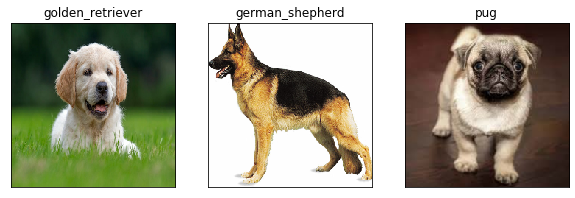

In [140]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_labels[i])
    plt.imshow(image)